##  Imports 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

##  1. CSV setup 

In [69]:
# 📂 Step 1: Load your raw sensor CSV (replace if needed)
file_path = '../test_csv/motor_temp_high.csv'  # <-- UPDATE THIS PATH if needed

# 1️⃣ Load the raw file
df_raw = pd.read_csv(file_path)

# 2️⃣ Convert timestamps properly
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])

# 3️⃣ Lock the row index for later tracing
df_raw['csv_index'] = df_raw.index

# 4️⃣ Print preview to confirm it's working
print("📋 First 5 rows of raw CSV:")
print(df_raw.head())

# 5️⃣ Confirm the index alignment is safe
index_check = all(df_raw['csv_index'] == df_raw.index)
print(f"\n✅ csv_index aligned with DataFrame index? {index_check}")

📋 First 5 rows of raw CSV:
            timestamp  feature_0 state  is_anomaly       sensor  csv_index
0 2025-04-07 00:00:00       22.0   off       False  temperature          0
1 2025-04-07 00:01:00       22.0   off       False  temperature          1
2 2025-04-07 00:02:00       22.0   off       False  temperature          2
3 2025-04-07 00:03:00       22.0   off       False  temperature          3
4 2025-04-07 00:04:00       22.0   off       False  temperature          4

✅ csv_index aligned with DataFrame index? True


## 2. Group by states

In [70]:
# 📂 Step 2: Filter temperature sensor & split by state

# 1️⃣ Filter to only the temperature sensor
df_temp = df_raw[df_raw['sensor'] == 'temperature'].copy()

# 2️⃣ Optional: Drop missing rows
df_temp = df_temp.dropna()

# 3️⃣ Print unique states to confirm
print("📊 Unique states in temperature sensor data:")
print(df_temp['state'].value_counts())

# 4️⃣ Show a few sample rows per state
print("\n📋 Sample 'run' state:")
print(df_temp[df_temp['state'] == 'run'].head(3))

print("\n📋 Sample 'off' state:")
print(df_temp[df_temp['state'] == 'off'].head(3))

print("\n📋 Sample 'idle' state:")
print(df_temp[df_temp['state'] == 'idle'].head(3))


📊 Unique states in temperature sensor data:
run     1184
off      150
idle     105
Name: state, dtype: int64

📋 Sample 'run' state:
              timestamp  feature_0 state  is_anomaly       sensor  csv_index
120 2025-04-07 02:00:00  55.945696   run       False  temperature        120
121 2025-04-07 02:01:00  60.113483   run       False  temperature        121
122 2025-04-07 02:02:00  56.776603   run       False  temperature        122

📋 Sample 'off' state:
            timestamp  feature_0 state  is_anomaly       sensor  csv_index
0 2025-04-07 00:00:00       22.0   off       False  temperature          0
1 2025-04-07 00:01:00       22.0   off       False  temperature          1
2 2025-04-07 00:02:00       22.0   off       False  temperature          2

📋 Sample 'idle' state:
             timestamp  feature_0 state  is_anomaly       sensor  csv_index
90 2025-04-07 01:30:00       22.0  idle       False  temperature         90
91 2025-04-07 01:31:00       22.0  idle       False  temperat

In [71]:
# 📂 Step 3: Normalize + sequence generation for 'run' state only (test)

# 1️⃣ Select 'run' state group
run_df = df_temp[df_temp['state'] == 'run'].copy()

# 2️⃣ Save csv_index for traceability
index_ref = run_df['csv_index'].values

# 3️⃣ Normalize the feature_0 column
scaler = MinMaxScaler()
run_scaled = scaler.fit_transform(run_df[['feature_0']])

# 4️⃣ Define sequence generator
def create_sequences_debug(data, index_ref, window=20):
    sequences, start_indices, end_indices = [], [], []
    for i in range(len(data) - window):
        sequences.append(data[i:i+window])
        start_indices.append(index_ref[i])
        end_indices.append(index_ref[i + window - 1])
    return np.array(sequences), start_indices, end_indices

# 5️⃣ Create sequences
seq_len = 20
X, start_idx, end_idx = create_sequences_debug(run_scaled, index_ref, window=seq_len)

# 6️⃣ Print debug of first sequence mapping
print(f"🔢 Number of sequences generated: {len(X)}")
print(f"🧩 First sequence uses raw CSV rows {start_idx[0]} to {end_idx[0]}")
print(f"🕓 Timestamps: {df_raw.loc[start_idx[0], 'timestamp']} → {df_raw.loc[end_idx[0], 'timestamp']}")
print(f"📈 Raw values (before scaling):")
print(run_df.loc[run_df['csv_index'].isin(range(start_idx[0], end_idx[0] + 1)), ['csv_index', 'feature_0']])

🔢 Number of sequences generated: 1164
🧩 First sequence uses raw CSV rows 120 to 139
🕓 Timestamps: 2025-04-07 02:00:00 → 2025-04-07 02:19:00
📈 Raw values (before scaling):
     csv_index  feature_0
120        120  55.945696
121        121  60.113483
122        122  56.776603
123        123  57.900950
124        124  55.887098
125        125  58.589067
126        126  59.812276
127        127  58.598619
128        128  57.021394
129        129  57.052306
130        130  57.600634
131        131  57.431729
132        132  57.030750
133        133  58.200357
134        134  57.775660
135        135  55.954832
136        136  57.822127
137        137  56.258630
138        138  56.328744
139        139  58.339180


Epoch 1/10


c:\Users\Thomas\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0154
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0044 
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035 
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

📊 Reconstruction threshold (95th percentile): 0.024803

📋 Sample predictions and their end_csv_index:
🔍 Row 0 | error=0.019322 | end_csv_index=1205 | timestamp=2025-04-07 20:05:00
🔍 Row 1 | error=0.018499 | end_csv_index=1206 | timestamp=2025-04-07 20:06:00
🔍 Row 2 | error=0.017024 | end_csv_index=1207 | timestamp=202

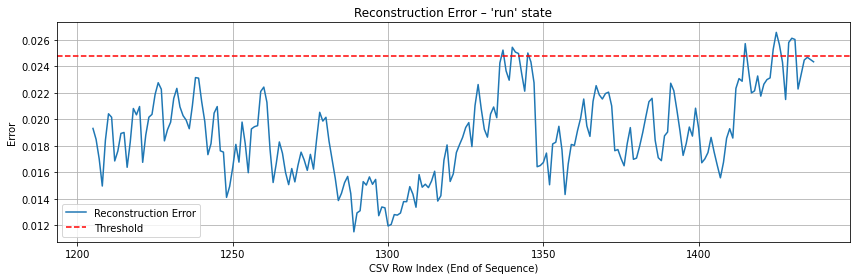

In [72]:
# 📂 Step 4: Train and test LSTM Autoencoder on 'run' state

# 1️⃣ Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
start_test = start_idx[split:]
end_test = end_idx[split:]

# 2️⃣ Build LSTM autoencoder model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=False),
    RepeatVector(X.shape[1]),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X.shape[2]))
])
model.compile(optimizer=Adam(1e-3), loss='mse')

# 3️⃣ Train the model
model.fit(X_train, X_train, epochs=10, batch_size=32, verbose=1)

# 4️⃣ Predict and calculate reconstruction error
X_pred = model.predict(X_test)
errors = np.mean(np.abs(X_pred - X_test), axis=(1, 2))

# 5️⃣ Threshold: 95th percentile
threshold = np.percentile(errors, 95)
print(f"\n📊 Reconstruction threshold (95th percentile): {threshold:.6f}")

# 6️⃣ Print sample errors + matched timestamps
print("\n📋 Sample predictions and their end_csv_index:")
for i in range(5):
    print(f"🔍 Row {i} | error={errors[i]:.6f} | end_csv_index={end_test[i]} | timestamp={df_raw.loc[end_test[i], 'timestamp']}")

# 7️⃣ Plot
plt.figure(figsize=(12, 4))
plt.plot(end_test, errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error – 'run' state")
plt.xlabel("CSV Row Index (End of Sequence)")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
# 📂 Step 5: Final result table for 'run' state

is_anomaly = (errors > threshold).astype(int)

result_df = pd.DataFrame({
    'start_csv_index': start_test,
    'end_csv_index': end_test,
    'timestamp': df_raw.loc[end_test, 'timestamp'].values,
    'state': 'run',
    'reconstruction_error': errors,
    'is_anomaly': is_anomaly
})

# 🧪 Print sample
print("📋 Final predictions sample:")
display(result_df.head(10))

# ✅ Save to variable for later
run_results_df = result_df.copy()


📋 Final predictions sample:


,start_csv_index,end_csv_index,timestamp,state,reconstruction_error,is_anomaly
0,1186,1205,2025-04-07 20:05:00,run,0.019322,0
1,1187,1206,2025-04-07 20:06:00,run,0.018499,0
2,1188,1207,2025-04-07 20:07:00,run,0.017024,0
3,1189,1208,2025-04-07 20:08:00,run,0.014977,0
4,1190,1209,2025-04-07 20:09:00,run,0.018427,0
5,1191,1210,2025-04-07 20:10:00,run,0.020428,0
6,1192,1211,2025-04-07 20:11:00,run,0.020165,0
7,1193,1212,2025-04-07 20:12:00,run,0.016868,0
8,1194,1213,2025-04-07 20:13:00,run,0.017613,0
9,1195,1214,2025-04-07 20:14:00,run,0.018944,0


In [74]:
# 📂 Stage 3: Filter out anomalies during state transitions

# 1️⃣ Set how many rows before/after a transition to flag
transition_window = 3

# 2️⃣ Re-merge run_results_df with all other states (if needed later)
transition_df = run_results_df.copy().reset_index(drop=True)
transition_df['is_transition'] = 0

# 3️⃣ Flag transitions (basic logic here assumes one state only, later we’ll do multi-state logic)
for i in range(1, len(transition_df)):
    if transition_df.loc[i, 'start_csv_index'] - transition_df.loc[i-1, 'end_csv_index'] > 1:
        for j in range(i - transition_window, i + transition_window + 1):
            if 0 <= j < len(transition_df):
                transition_df.loc[j, 'is_transition'] = 1

# 4️⃣ Final filtered anomalies
final_anomalies_df = transition_df[
    (transition_df['is_anomaly'] == 1) & (transition_df['is_transition'] == 0)
]

# 5️⃣ Show sample
print(f"✅ Final anomaly count (after transition filter): {len(final_anomalies_df)}")
display(final_anomalies_df.head(10))


✅ Final anomaly count (after transition filter): 12


,start_csv_index,end_csv_index,timestamp,state,reconstruction_error,is_anomaly,is_transition
132,1318,1337,2025-04-07 22:17:00,run,0.025234,1,0
135,1321,1340,2025-04-07 22:20:00,run,0.025446,1,0
136,1322,1341,2025-04-07 22:21:00,run,0.025083,1,0
137,1323,1342,2025-04-07 22:22:00,run,0.024974,1,0
140,1326,1345,2025-04-07 22:25:00,run,0.025014,1,0
210,1396,1415,2025-04-07 23:35:00,run,0.025721,1,0
219,1405,1424,2025-04-07 23:44:00,run,0.025286,1,0
220,1406,1425,2025-04-07 23:45:00,run,0.026570,1,0
221,1407,1426,2025-04-07 23:46:00,run,0.025639,1,0
224,1410,1429,2025-04-07 23:49:00,run,0.025808,1,0
